# Data
The dataset that we will be using is the Celeba Dataset. It contains 10,177 different people with 202,599 total photos. All the images in the dataset are 218x178px 3-channel jpg images stored in one massive folder. These images are paired with five text files describing the boundary boxes of faces, file identities, 40 binary facial attributes, and 5 facial landmark locations. It should also be noted that each image has strictly one face.

Due to the absolutely massive size of the dataset (27.6GB), we used a variant that was already uploaded to Kaggle [this](https://www.kaggle.com/jessicali9530/celeba-dataset). This dataset claims to be the same but is missing the identities file which was needed for our project so it was created as its own dataset [here](https://www.kaggle.com/kymo9890/identity-celeba). Since the filenames are just increasing numbers the identities file is needed to naively map each file name to an identity. This is a CSV with space delimiters mapping each filename to a numeric identity. The identity of each photo in the set will allow us to create an image generator matching all faces to an identity. The dataset also contains feature sets (such as curly hair, glasses, etc.), but these were not useful because our model focuses on creating its own feature set modeled after all faces in the dataset.

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import glob

%matplotlib inline

# EDA
In order to train the model we will need to spend some time learning about our data. The data set itself was very well documented; our main concern was verifying the documentation that was provided to us was indeed correct. It was first confirmed that all identities were being mapped to files in the `identity_CelebA.txt` file. This was done by reading the file into a Pandas dataframe and grouping the data by the `identity` field and then aggregating the counts. We then plotted this data on a histogram to visualize the distribution of files per identity. There were a few identities that had only 1 image associated with them. The maximum amount of files per identity was 35. Overall, the distribution of files to identities was workable. 

First we examine the distribution of photos per identity. We see that there are several identities that have very few photos.

In [2]:
identities_file = '/kaggle/input/identity-celeba/identity_CelebA.txt'
identities = pd.read_csv(identities_file, delimiter=' ', names=['file', 'identity'])

identities

,file,identity
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295
...,...,...
202594,202595.jpg,9761
202595,202596.jpg,7192
202596,202597.jpg,9852
202597,202598.jpg,5570


Min count: 1
Max count: 35


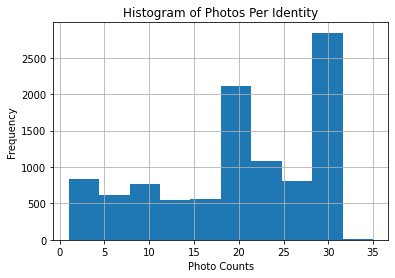

In [3]:
counts = identities.groupby('identity').agg(['count'])
counts.hist()
plt.title('Histogram of Photos Per Identity')
plt.xlabel('Photo Counts')
plt.ylabel('Frequency')

print('Min count: %d' % counts.min())
print('Max count: %d' % counts.max())

Next, the images themselves were explored. The image shape was printed out to confirm it was indeed a 218x178 photo with 3 channels. The min and max values of the image matrix were printed out to confirm that the images bytes lie between 0 and 255. We then confirmed that every image was of the same size and that all images were in-fact RGB. There were some very interesting images that failed this check. Some of these are terrifying and do not even resemble faces.

Image Shape: (218, 178, 3)
Image Min/Max Values: 0/255


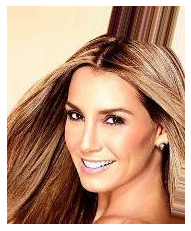

In [4]:
source_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/%s'

test_file = source_dir % identities['file'].iloc[0]

test_image = cv.imread(test_file)

print('Image Shape:', test_image.shape)
print('Image Min/Max Values: %s/%s' % (test_image.min(), test_image.max()))
plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))

plt.axis('off');

Performing a sanity check to confirm that a all the images in an identity are indeed the same person.

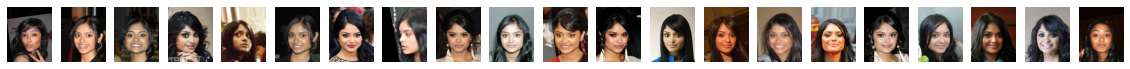

In [5]:
group = identities[identities.identity == 99]

fig, ax = plt.subplots(1, len(group), figsize=(20,20))
i = 0
for _, file, identity in list(group.itertuples()):
    ax[i].imshow(cv.cvtColor(cv.imread(source_dir % file), cv.COLOR_BGR2RGB))
    ax[i].axis('off')
    i += 1
plt.show()

Next we are going to validate that all the images are of the same size and check if any are grayscale

In [6]:
def is_gray(image):
    #https://stackoverflow.com/a/58791118/2821370
    b,g,r = image[:,:,0], image[:,:,1], image[:,:,2] # extract bgr chanels 
    return (b==g).all() and (b==r).all()

bad_images = []
bad_identities = []
for _, file, identity in tqdm(list(identities.itertuples())):
    image = cv.imread(source_dir % file)
    bad = False
    if image.shape != (218, 178, 3): # check the shape
        print(file, 'is of the wrong shape:', image.shape)
        bad = True
    if is_gray(image):
        print(file, 'is grayscale')
        bad = True
    
    if bad:
        bad_images.append(file)
        bad_identities.append(identity)

001646.jpg is grayscale
007494.jpg is grayscale
009397.jpg is grayscale
011793.jpg is grayscale
015989.jpg is grayscale
016530.jpg is grayscale
019205.jpg is grayscale
020441.jpg is grayscale
024184.jpg is grayscale
026135.jpg is grayscale
031125.jpg is grayscale
031185.jpg is grayscale
038081.jpg is grayscale
039459.jpg is grayscale
040411.jpg is grayscale
041897.jpg is grayscale
046959.jpg is grayscale
048286.jpg is grayscale
048501.jpg is grayscale
053824.jpg is grayscale
080480.jpg is grayscale
080624.jpg is grayscale
084360.jpg is grayscale
092651.jpg is grayscale
099993.jpg is grayscale
102061.jpg is grayscale
103007.jpg is grayscale
115630.jpg is grayscale
119379.jpg is grayscale
121050.jpg is grayscale
128464.jpg is grayscale
131065.jpg is grayscale
139373.jpg is grayscale
153323.jpg is grayscale
163984.jpg is grayscale
168048.jpg is grayscale
169131.jpg is grayscale
174980.jpg is grayscale
176742.jpg is grayscale
179577.jpg is grayscale
191378.jpg is grayscale
195995.jpg is gr

Some of these images are extermely difficult to interpret as belonging to a person. This is nightmare fuel.

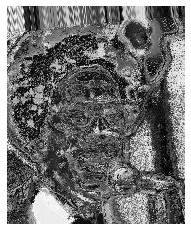

In [7]:
gray_image = '011793.jpg'
plt.imshow(cv.cvtColor(cv.imread(source_dir % gray_image), cv.COLOR_BGR2RGB))
plt.axis('off');

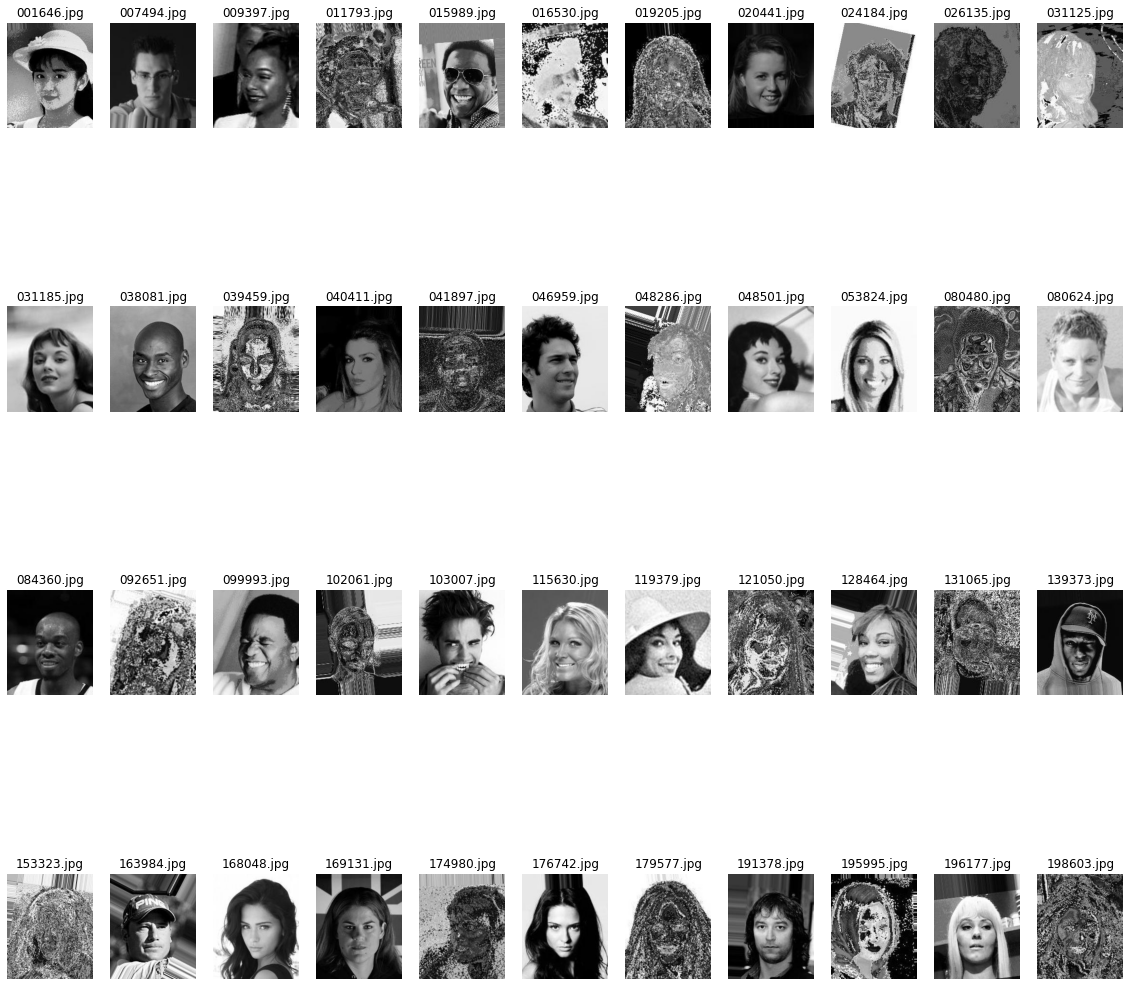

In [8]:
fig, ax = plt.subplots(4, 11, figsize=(20,20))
i = 0
for r in range(0,4):
    for c in range(0,11):
        ax[r,c].imshow(cv.cvtColor(cv.imread(source_dir % bad_images[i]), cv.COLOR_BGR2RGB))
        ax[r,c].axis('off')
        ax[r,c].set_title(bad_images[i])
        i+=1
plt.show()

# Data Cleaning
The images in our dataset were relatively clean from the start but modifications were needed to achieve the best possible results.

Firstly, there were several black and white images littered throughout our colored images. Most of these B&W images also had significant distortions so all of these images were excluded from the dataset. We then made the rest of the images black and white using OpenCV. This was done because it greatly simplified the training process and tripled the number of images that could be stored in memory.

Next, we addressed the cropping of the images. So far, the images were not cropped according to our facial detection algorithm. We used Haar-cascade detection with a default feature set to detect and extract faces in a scene. We ran all of the images in the dataset through this extraction process for two reasons. Firstly, to ensure that a face was present in the image. And second, to ensure that our cropping would be consistent in our training as it would be with our application. This also ensured that all images in our dataset were centered in the image.

Through this approach, we were able to ensure a high level of consistency in our dataset. Going forward, we did not notice any other issues with the data. One of the most difficult aspects of the data cleaning was the sheer amount of files that we needed to modify. There are over 200,000 files in the dataset which means that this cleaning could take ages. We were able to make it work by only cleaning a small subset of the images and using that for our train/test set.

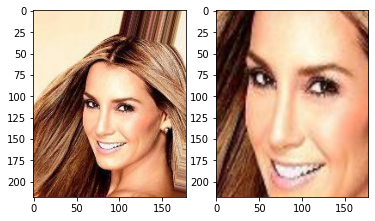

In [9]:
# First, we built out the code required to extract faces from a scene. We then ran a few sanity checks to make sure our code worked as intended.
# https://realpython.com/traditional-face-detection-python/
face_cascade = cv.CascadeClassifier('/kaggle/input/haarcascades/haarcascade_frontalface_alt.xml')

def detect_faces(img):
    grey_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    detected_faces = face_cascade.detectMultiScale(grey_image)
    return detected_faces

def crop_face(img):
    faces = detect_faces(img)
    if len(faces) == 0:
        return img
    else:
        column, row, width, height = faces[0]
        cropped = img[row:row+height, column:column+width]
        return cv.resize(cropped, img.shape[0:2][::-1])

image = cv.imread('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(crop_face(image));

### Setting Up Test/Train Directories
Due to processing limitation, it is impossible to train on the entire dataset as either images have to be continously loaded and unloaded or all the images have to be loaded into memory. Neither of these are viable. Reading a subset of the data into memory would allow much faster training while not using all of the ram.

A train/test split of 1000-100 made for a good balance between memory usage and amount of data available to train on. This 1000-100 represents the amount of identities used in the train/test process.

This was also an opportunity to check and make sure there was a face in every picture.

In [10]:
# Each identity has to have its own folder
import pandas as pd
from shutil import copyfile

# The first 1100 identites were confirmed clean from the EDA
train_size = 1000
test_size = train_size // 10

!rm -rf /kaggle/working/train && rm -rf /kaggle/working/train

target_dir_train = '/kaggle/working/train/%d/'
target_dir_test = '/kaggle/working/test/%d/'
    
def check_face_image(file):
    image = cv.imread(file)
    return len(detect_faces(image)) == 1

total_files = train_size + test_size
print('copying', train_size + test_size, 'identities')
no_face_found_files = []

for _, file, identity in tqdm(list(identities[identities.identity <= total_files].itertuples())):
    if identity <= train_size:
        dest_dir =  target_dir_train
    elif identity <= train_size + test_size:
        dest_dir = target_dir_test
        
    dest_dir = dest_dir % identity
    if file not in bad_images:
        if check_face_image(source_dir % file):
            os.makedirs(dest_dir, exist_ok=True)
            copyfile(source_dir % file, dest_dir + file)
        else:
            no_face_found_files.append(file)

copying 1100 identities


In [11]:
len(no_face_found_files)

1078

This is a sanity test to make sure nothing got mixed up during the file manipulation. All the files pertaining to an identity should all be the same person.

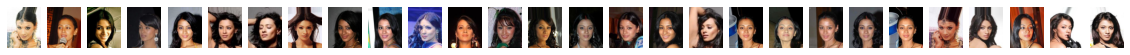

In [12]:
def show_class(class_name, cl='train'):
    # Check to make sure that all files in each directory are of the same person (sanity check)
    files = glob.glob('/kaggle/working/%s/%s/*' % (cl, class_name))

    fig, ax = plt.subplots(1, len(files), figsize=(20,10))
    for index, file in enumerate(files):
        ax[index].imshow(cv.cvtColor(cv.imread(file), cv.COLOR_BGR2RGB))
        ax[index].axis('off')
    plt.show()
    
show_class('1006', 'test')

# Modeling

One of the most significant hurdles is creating a way to classify thousands of classes within a single Neural Network. The ability to classify among an infinite number of classes in our project is accomplished through a method called One-Shot Learning. Another advantage offered with this method is that we can write a train once, run anywhere algorithm. 

In [13]:
# Create the image preprocessor 
from keras.preprocessing.image import ImageDataGenerator
import random

# Define the train/test directories for images
train_directory = '/kaggle/working/train/'
test_directory = '/kaggle/working/test/'
batch_size = 128

# A DirectoryFlow is a way to store a bunch of images from a directory structure in memory for training
# Each image is stored in a subdirectory given by its class, the image names are meaningless
class DirectoryFlow:
    def __init__(self, directory, batch_size, in_memory=True):
        self.directory = directory
        self.batch_size = batch_size
        self.in_memory = in_memory
        if in_memory:
            self.file_structure = self.load_images(directory)
        else: 
            self.file_structure = {int(f): [directory + '%s/%s' % (f, file_name) for file_name in os.listdir(directory + f)] for f in os.listdir(directory)}
        self.classes = list(self.file_structure.keys())
        print('Loaded %d classes' % len(self.classes))
    
    # loads all of the images in the directory into memory
    def load_images(self, directory):
        structure = {}
        for f in tqdm(os.listdir(directory)):
            structure[int(f)] = [self.read_image(directory + '%s/%s' % (f, file_name)) for file_name in os.listdir(directory + f)]
        return structure
    
    # does the preprocessing work for an image
    # this involves: resizing, b&w, cropping, rescaling, and reshaping the image
    def read_image(self, file):
        img = cv.imread(file)
        img = cv.resize(img, (64, 64))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = crop_face(img.astype('uint8'))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = img.astype('float32')/255
        img = img.reshape(*img.shape, 1)
        return img
    
    # this returns a random image from a class
    # if no class is given, the method will chose a random class
    def next(self, class_name=None):
        if class_name is None:
            class_name = random.choice(self.classes)
        item = random.choice(self.file_structure[class_name])
        
        if self.in_memory:
            return item, class_name
        else:
            return self.read_image(item), class_name
    
    def next_batch(self):
        images = []
        labels = np.zeros((self.batch_size))
        for i in range(self.batch_size):
            image, class_name = self.next()
            images.append(image)
            labels[i] = class_name
        return np.array(images), labels

datagen_train = DirectoryFlow(train_directory, batch_size)
datagen_test = DirectoryFlow(test_directory, batch_size)

Using TensorFlow backend.



Loaded 1000 classes



Loaded 100 classes


We tried two variations of a "Siamese Neural Network." It combines two identical CNN models that identify facial features present in an image and then combines the two models into a final third model. This third model computes the similarity between the two images. Zero meaning the faces are different and one meaning they are the same. 

These models are based heavily on another model linked at the top of the code cell.

One of the most difficult part of working with CNNs is getting the output shapes to be what you want. Messing around with different strides and kernel sizes for a while resulted in this model.

In [14]:
# https://github.com/aleju/face-comparer/blob/master/train.py#L252
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Dense, Add, Conv2D, MaxPooling2D, Lambda, BatchNormalization, GaussianNoise
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K

input_shape = (64, 64, 1)

def make_facial_feature_cnn():
    network_input = Input(shape=input_shape)
    face = Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same', name='conv1')(network_input)
    face = Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same', name='conv2')(face)
    face = Conv2D(64, kernel_size=(8,8), strides=(3,3), activation='relu', padding='same', name='conv3')(face)

    face = Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same', name='conv4')(face)
    face = Conv2D(64, kernel_size=(9,9), strides=(4,4), activation='relu', padding='same', name='conv5')(face)
    face = Conv2D(32, kernel_size=(5,5), strides=(2,2), activation='relu', padding='same', name='conv6')(face)
    
    face = Flatten()(face)
    face= Dropout(0.15)(face)
    face = Dense(32, activation='tanh')(face)
    face = BatchNormalization()(face)

    return Model(network_input, face)

facial_feature_cnn = make_facial_feature_cnn()

input_face_left = Input(shape=input_shape, name='model_face_left')
input_face_right = Input(shape=input_shape, name='model_face_right')

model_face_left = facial_feature_cnn(input_face_left)
model_face_right = facial_feature_cnn(input_face_right)

merged_model = Lambda(lambda tensors: abs(tensors[0] - tensors[1]), name='absolute_difference')([model_face_left, model_face_right])
merged_model = GaussianNoise(0.5)(merged_model)
merged_model = Dense(64, activation='relu', name='d1')(merged_model)
merged_model = Dropout(0.1, name='drop1')(merged_model)
merged_model = Dense(1, activation='sigmoid', name='out')(merged_model)

model = Model(inputs=[input_face_left, input_face_right], outputs=merged_model, name='lr_merger')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(facial_feature_cnn.summary())
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        25632     
_________________________________________________________________
conv3 (Conv2D)               (None, 22, 22, 64)        131136    
_________________________________________________________________
conv4 (Conv2D)               (None, 22, 22, 32)        51232     
_________________________________________________________________
conv5 (Conv2D)               (None, 6, 6, 64)          165952    
_________________________________________________________________
conv6 (Conv2D)               (None, 3, 3, 32)          5123

Our second model adds more randomness to the first in the hopes of preventing overfitting of the data. This model ended up performing better than the first likely due to the additional randomness.

This randomness is added in through several LeakyReLU activations between several of the CNN layers. This is continued with gausian noise and dropout layers in the merged model.

In [15]:
# https://github.com/aleju/face-comparer/blob/master/train.py#L252
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Dense, Add, Conv2D, MaxPooling2D, Lambda, BatchNormalization, GaussianNoise, LeakyReLU
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K

input_shape = (64, 64, 1)

def make_facial_feature_cnn():
    network_input = Input(shape=input_shape, )
    face = Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', name='conv1')(network_input)
    face = LeakyReLU(0.2)(face)
    face = Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', name='conv2')(face)
    face = LeakyReLU(0.2)(face)
    face = Conv2D(64, kernel_size=(8,8), strides=(3,3), padding='same', name='conv3')(face)
    face = LeakyReLU(0.2)(face)
    
    face = Conv2D(64, kernel_size=(5,5), strides=(1,1), padding='same', name='conv4')(face)
    face = LeakyReLU(0.2)(face)
    face = Conv2D(128, kernel_size=(9,9), strides=(4,4), padding='same', name='conv5')(face)
    face = LeakyReLU(0.2)(face)
    face = Conv2D(128, kernel_size=(5,5), strides=(2,2), padding='same', name='conv6')(face)
    face = LeakyReLU(0.2)(face)
    face= Dropout(0.15)(face)

    face = Flatten()(face)
    face = Dense(512)(face)
    face = BatchNormalization()(face)
    face = Activation('tanh')(face)

    return Model(network_input, face)

facial_feature_cnn = make_facial_feature_cnn()

input_face_left = Input(shape=input_shape, name='model_face_left')
input_face_right = Input(shape=input_shape, name='model_face_right')

model_face_left = facial_feature_cnn(input_face_left)
model_face_right = facial_feature_cnn(input_face_right)

merged_model = Lambda(lambda tensors: abs(tensors[0] - tensors[1]), name='absolute_difference')([model_face_left, model_face_right])
merged_model = GaussianNoise(0.25)(merged_model)
merged_model = Dense(256, name='d1')(merged_model)
merged_model = BatchNormalization()(merged_model)
merged_model = LeakyReLU(0.2)(merged_model)
merged_model = Dropout(0.15, name='drop1')(merged_model)
merged_model = Dense(1, activation='sigmoid', name='out')(merged_model)

model = Model(inputs=[input_face_left, input_face_right], outputs=merged_model, name='lr_merger')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(facial_feature_cnn.summary())
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        25632     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 22, 22, 64)        131136    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 22, 22, 64)        0   

It's fun to be able to visualize the model while you are building it. The following gives a rough overview of what the model looks like.

rm: cannot remove '/kaggle/working/model.png': No such file or directory


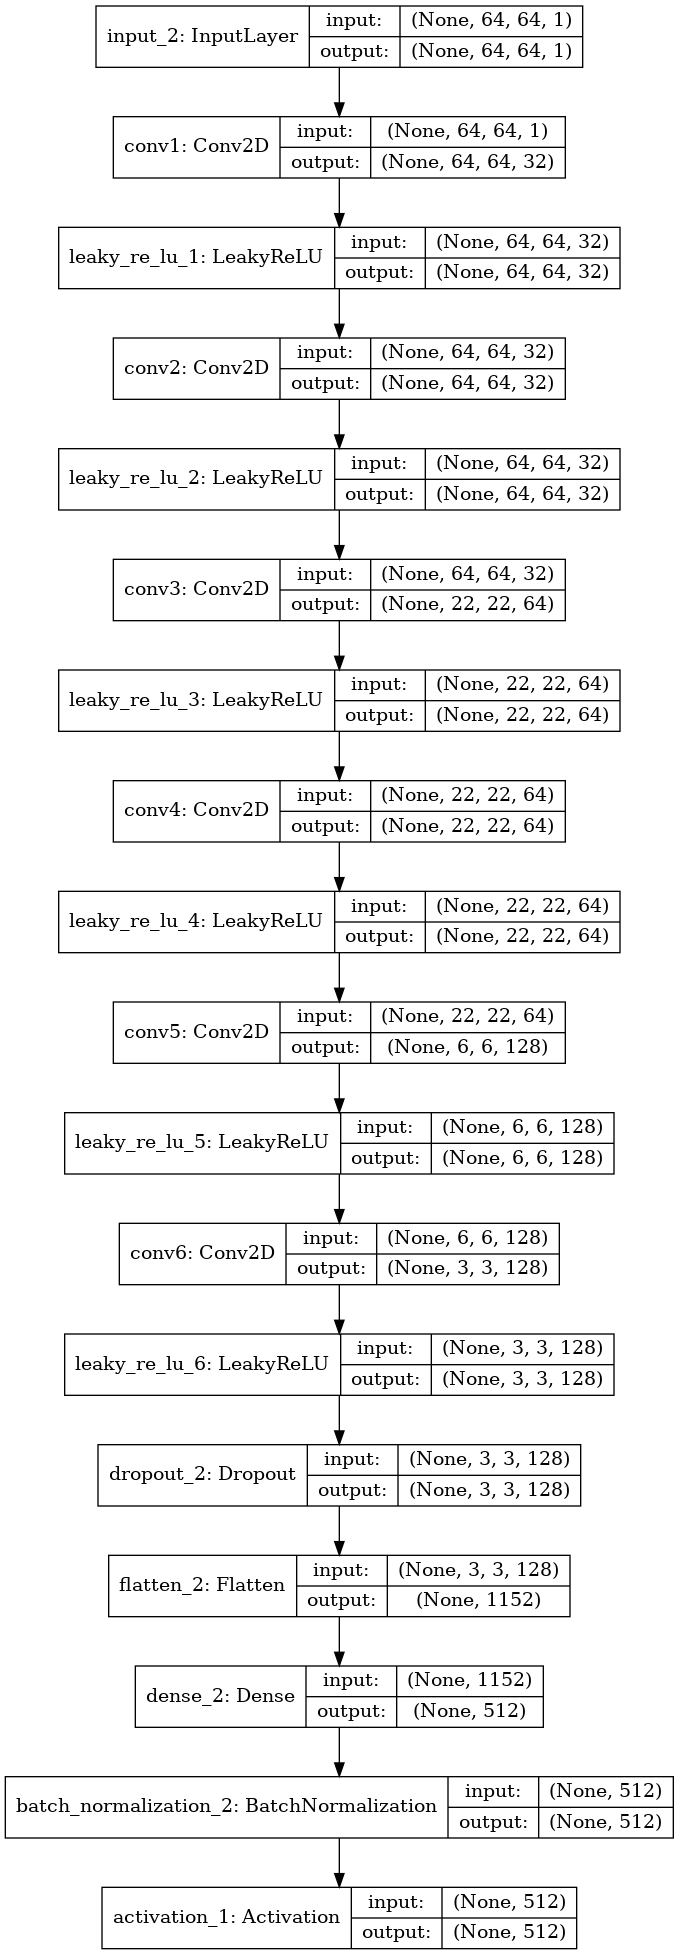

In [16]:
from IPython.display import Image
from keras.utils import plot_model

!rm /kaggle/working/model.png
plot_model(facial_feature_cnn, to_file='/kaggle/working/model_base.png', show_shapes=True)
Image('/kaggle/working/model_base.png')

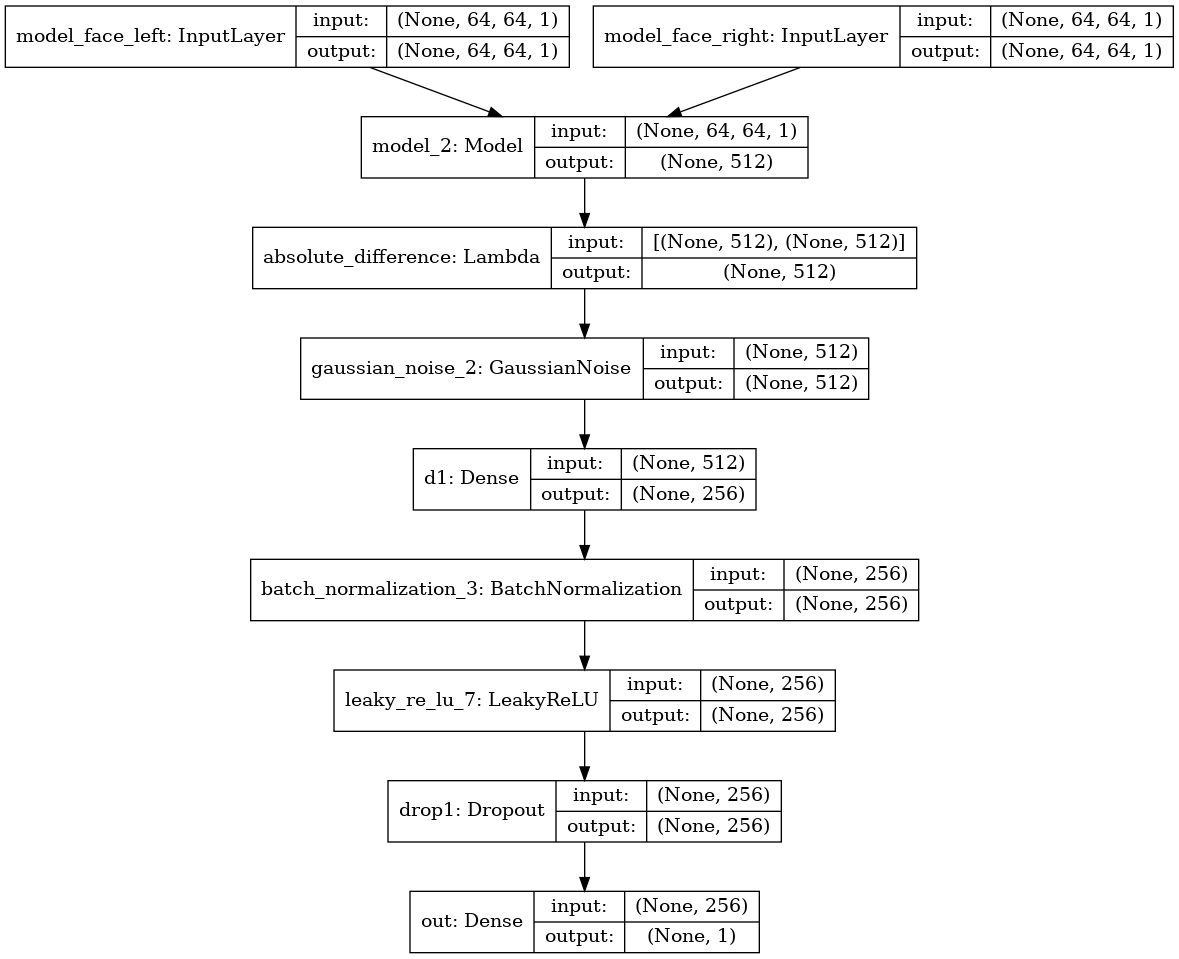

In [17]:
plot_model(model, to_file='/kaggle/working/model.png', show_shapes=True)
Image('/kaggle/working/model.png')

Finally, there needs to be a way to feed our data into Keras. This was done through this batch iterator. It basiclly sets up the image training pairs and sends them to Keras.

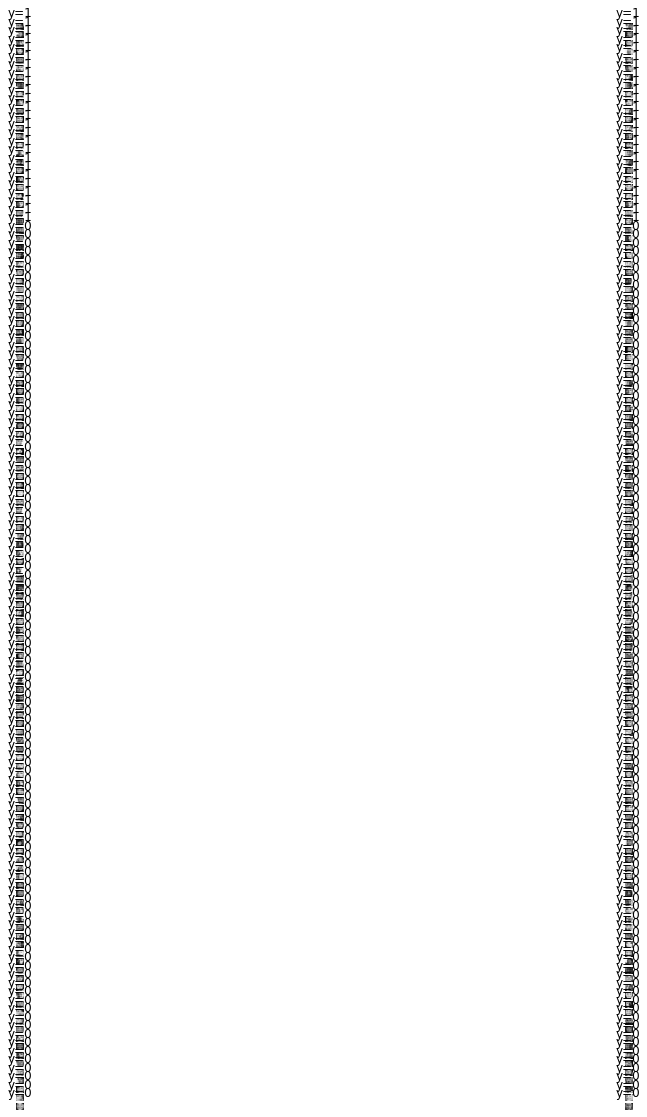

In [18]:
class CustomBatchIterator:
    def __init__(self, datagen, batch_size):
        self.datagen = datagen
        self.batch_size = batch_size
        
    def make_batch(self):
        images, labels = self.datagen.next_batch()

        # batches have 2 image arrays
        output_pairs = [np.zeros((self.batch_size, *images[0].shape)) for i in range(2)]
        # output labels: 0 for different, 1 for same
        output_labels = np.zeros(self.batch_size)
        
        same_image_count = np.random.randint(1, self.batch_size) # each batch has a random number of same/different images
        output_labels[:same_image_count] = 1

        for i in range(same_image_count):
            label = labels[i]
            random_image,_ = self.datagen.next(label) # load an image of the same class
            output_pairs[0][i] = images[i]
            output_pairs[1][i] = random_image

        for i in range(same_image_count, self.batch_size):
            label = labels[i]
            while True: # find a label for a different class
                random_label = random.choice(self.datagen.classes)
                if random_label != label: break
            random_image,_ = self.datagen.next(random_label) # load an image for the other classes' label
            output_pairs[0][i] = images[i]
            output_pairs[1][i] = random_image

        return output_pairs, output_labels
    
    def __iter__(self):
        return self

    def __next__(self):
        return self.make_batch()

# Sanity check to make sure the batches look right
def show_batch_pairs(image_batch_pairs, label_batch):
    fig, ax = plt.subplots(len(image_batch_pairs[0]), 2, figsize=(20,20))
    for r in range(len(image_batch_pairs[0])):
        for c in [0,1]:
            image = image_batch_pairs[c][r]
            ax[r,c].imshow(image[:,:,0], cmap='gray')
            ax[r,c].axis('off')
            ax[r,c].set_title('y=%d' % label_batch[r])
            
train_it = CustomBatchIterator(datagen_train, batch_size)
test_it  = CustomBatchIterator(datagen_test, batch_size)
show_batch_pairs(*next(train_it))

Finally, run the training proceedure. After around 500 epochs the model has converged on a solution.

At this point we further tuned the model by looking at the convergence of accuracy over 100 epochs for different optimization methods. We found that our second model generally outperformed the first.

In [19]:
history = model.fit_generator(train_it, steps_per_epoch=10, epochs=1000, validation_data=test_it, validation_steps=10)

Epoch 1/1000
10/10 [==============================] - 6s 628ms/step - loss: 0.8036 - accuracy: 0.5141 - val_loss: 0.7061 - val_accuracy: 0.4891
Epoch 2/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.8007 - accuracy: 0.5047 - val_loss: 0.6560 - val_accuracy: 0.5898
Epoch 3/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.7974 - accuracy: 0.5000 - val_loss: 0.5750 - val_accuracy: 0.3609
Epoch 4/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.7934 - accuracy: 0.5047 - val_loss: 0.6019 - val_accuracy: 0.5188
Epoch 5/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.7653 - accuracy: 0.5008 - val_loss: 0.6469 - val_accuracy: 0.5664
Epoch 6/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.7242 - accuracy: 0.5484 - val_loss: 0.5021 - val_accuracy: 0.7320
Epoch 7/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.8173 - accuracy: 0.4852 - val_loss: 0.8827 - val_accuracy:

10/10 [==============================] - 1s 124ms/step - loss: 0.7410 - accuracy: 0.5008 - val_loss: 0.5959 - val_accuracy: 0.5164
Epoch 58/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.7104 - accuracy: 0.5445 - val_loss: 0.5339 - val_accuracy: 0.4820
Epoch 59/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.6994 - accuracy: 0.5469 - val_loss: 0.6150 - val_accuracy: 0.4531
Epoch 60/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6990 - accuracy: 0.5406 - val_loss: 0.5038 - val_accuracy: 0.6047
Epoch 61/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.7094 - accuracy: 0.5430 - val_loss: 0.5963 - val_accuracy: 0.4125
Epoch 62/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6872 - accuracy: 0.5609 - val_loss: 0.7479 - val_accuracy: 0.5500
Epoch 63/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6906 - accuracy: 0.5617 - val_loss: 0.5090 - val_accuracy: 0.5859

10/10 [==============================] - 1s 124ms/step - loss: 0.6742 - accuracy: 0.5750 - val_loss: 0.5715 - val_accuracy: 0.6008
Epoch 114/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6902 - accuracy: 0.5820 - val_loss: 0.6983 - val_accuracy: 0.6227
Epoch 115/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6746 - accuracy: 0.5859 - val_loss: 0.6575 - val_accuracy: 0.5891
Epoch 116/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.6849 - accuracy: 0.5578 - val_loss: 0.5528 - val_accuracy: 0.6281
Epoch 117/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6587 - accuracy: 0.6023 - val_loss: 0.7860 - val_accuracy: 0.5414
Epoch 118/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6804 - accuracy: 0.5820 - val_loss: 0.7048 - val_accuracy: 0.5594
Epoch 119/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6635 - accuracy: 0.5992 - val_loss: 0.6194 - val_accuracy: 

10/10 [==============================] - 1s 127ms/step - loss: 0.6381 - accuracy: 0.6313 - val_loss: 0.6191 - val_accuracy: 0.6430
Epoch 170/1000
10/10 [==============================] - 1s 132ms/step - loss: 0.6535 - accuracy: 0.6133 - val_loss: 0.6153 - val_accuracy: 0.6250
Epoch 171/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.6571 - accuracy: 0.6109 - val_loss: 0.7111 - val_accuracy: 0.6164
Epoch 172/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6681 - accuracy: 0.6078 - val_loss: 0.6769 - val_accuracy: 0.6234
Epoch 173/1000
10/10 [==============================] - 1s 131ms/step - loss: 0.6740 - accuracy: 0.5883 - val_loss: 0.5919 - val_accuracy: 0.6422
Epoch 174/1000
10/10 [==============================] - 1s 129ms/step - loss: 0.6594 - accuracy: 0.6109 - val_loss: 0.5853 - val_accuracy: 0.6695
Epoch 175/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6550 - accuracy: 0.6055 - val_loss: 0.5724 - val_accuracy: 

10/10 [==============================] - 1s 133ms/step - loss: 0.6509 - accuracy: 0.6227 - val_loss: 0.5968 - val_accuracy: 0.5961
Epoch 226/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6095 - accuracy: 0.6672 - val_loss: 0.7182 - val_accuracy: 0.6422
Epoch 227/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.6364 - accuracy: 0.6305 - val_loss: 0.7334 - val_accuracy: 0.5797
Epoch 228/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.6704 - accuracy: 0.6062 - val_loss: 0.7138 - val_accuracy: 0.6562
Epoch 229/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6850 - accuracy: 0.5734 - val_loss: 0.6351 - val_accuracy: 0.6523
Epoch 230/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6649 - accuracy: 0.5984 - val_loss: 0.6021 - val_accuracy: 0.6367
Epoch 231/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6629 - accuracy: 0.6000 - val_loss: 0.6112 - val_accuracy: 

10/10 [==============================] - 1s 124ms/step - loss: 0.6395 - accuracy: 0.6289 - val_loss: 0.5536 - val_accuracy: 0.6695
Epoch 282/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6281 - accuracy: 0.6508 - val_loss: 0.5344 - val_accuracy: 0.7125
Epoch 283/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6370 - accuracy: 0.6289 - val_loss: 0.5875 - val_accuracy: 0.7156
Epoch 284/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6129 - accuracy: 0.6555 - val_loss: 0.4758 - val_accuracy: 0.7133
Epoch 285/1000
10/10 [==============================] - 1s 123ms/step - loss: 0.6328 - accuracy: 0.6336 - val_loss: 0.5663 - val_accuracy: 0.6898
Epoch 286/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.6667 - accuracy: 0.5977 - val_loss: 0.5652 - val_accuracy: 0.7086
Epoch 287/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6339 - accuracy: 0.6258 - val_loss: 0.4840 - val_accuracy: 

10/10 [==============================] - 1s 125ms/step - loss: 0.6365 - accuracy: 0.6367 - val_loss: 0.5603 - val_accuracy: 0.6883
Epoch 338/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.5896 - accuracy: 0.6914 - val_loss: 0.5793 - val_accuracy: 0.7258
Epoch 339/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6349 - accuracy: 0.6359 - val_loss: 0.4586 - val_accuracy: 0.7047
Epoch 340/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6090 - accuracy: 0.6547 - val_loss: 0.5339 - val_accuracy: 0.7070
Epoch 341/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6353 - accuracy: 0.6492 - val_loss: 0.5022 - val_accuracy: 0.7117
Epoch 342/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6174 - accuracy: 0.6250 - val_loss: 0.6077 - val_accuracy: 0.7289
Epoch 343/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.6022 - accuracy: 0.6633 - val_loss: 0.5058 - val_accuracy: 

10/10 [==============================] - 1s 124ms/step - loss: 0.6379 - accuracy: 0.6258 - val_loss: 0.5396 - val_accuracy: 0.7484
Epoch 394/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5852 - accuracy: 0.6883 - val_loss: 0.4756 - val_accuracy: 0.7172
Epoch 395/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5713 - accuracy: 0.6898 - val_loss: 0.5539 - val_accuracy: 0.7141
Epoch 396/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.5912 - accuracy: 0.6672 - val_loss: 0.4574 - val_accuracy: 0.7055
Epoch 397/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6325 - accuracy: 0.6461 - val_loss: 0.5543 - val_accuracy: 0.7188
Epoch 398/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5719 - accuracy: 0.6820 - val_loss: 0.5988 - val_accuracy: 0.6758
Epoch 399/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5734 - accuracy: 0.6898 - val_loss: 0.5586 - val_accuracy: 

10/10 [==============================] - 1s 125ms/step - loss: 0.5721 - accuracy: 0.6797 - val_loss: 0.4480 - val_accuracy: 0.7484
Epoch 450/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.5473 - accuracy: 0.7070 - val_loss: 0.4147 - val_accuracy: 0.7273
Epoch 451/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5937 - accuracy: 0.6680 - val_loss: 0.6018 - val_accuracy: 0.7148
Epoch 452/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6514 - accuracy: 0.6375 - val_loss: 0.5573 - val_accuracy: 0.7344
Epoch 453/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.6080 - accuracy: 0.6500 - val_loss: 0.5063 - val_accuracy: 0.7367
Epoch 454/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.5854 - accuracy: 0.6875 - val_loss: 0.4888 - val_accuracy: 0.7398
Epoch 455/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6170 - accuracy: 0.6672 - val_loss: 0.4755 - val_accuracy: 

10/10 [==============================] - 1s 131ms/step - loss: 0.5844 - accuracy: 0.7023 - val_loss: 0.4425 - val_accuracy: 0.7508
Epoch 506/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.6168 - accuracy: 0.6867 - val_loss: 0.3690 - val_accuracy: 0.7672
Epoch 507/1000
10/10 [==============================] - 1s 123ms/step - loss: 0.5849 - accuracy: 0.7172 - val_loss: 0.5163 - val_accuracy: 0.7125
Epoch 508/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5388 - accuracy: 0.7383 - val_loss: 0.4536 - val_accuracy: 0.7516
Epoch 509/1000
10/10 [==============================] - 1s 133ms/step - loss: 0.5558 - accuracy: 0.6977 - val_loss: 0.4676 - val_accuracy: 0.7477
Epoch 510/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5616 - accuracy: 0.7188 - val_loss: 0.4172 - val_accuracy: 0.7523
Epoch 511/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5547 - accuracy: 0.7016 - val_loss: 0.3909 - val_accuracy: 

10/10 [==============================] - 1s 125ms/step - loss: 0.5032 - accuracy: 0.7688 - val_loss: 0.6172 - val_accuracy: 0.6977
Epoch 562/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.5492 - accuracy: 0.7188 - val_loss: 0.4667 - val_accuracy: 0.7406
Epoch 563/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.5624 - accuracy: 0.7078 - val_loss: 0.5302 - val_accuracy: 0.7555
Epoch 564/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.4946 - accuracy: 0.7633 - val_loss: 0.4790 - val_accuracy: 0.7047
Epoch 565/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5640 - accuracy: 0.7234 - val_loss: 0.5866 - val_accuracy: 0.7422
Epoch 566/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.5184 - accuracy: 0.7281 - val_loss: 0.6313 - val_accuracy: 0.7367
Epoch 567/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.5454 - accuracy: 0.7461 - val_loss: 0.5451 - val_accuracy: 

10/10 [==============================] - 1s 125ms/step - loss: 0.4855 - accuracy: 0.7594 - val_loss: 0.4918 - val_accuracy: 0.7305
Epoch 618/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.4894 - accuracy: 0.7484 - val_loss: 0.4339 - val_accuracy: 0.7258
Epoch 619/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.4731 - accuracy: 0.7656 - val_loss: 0.5868 - val_accuracy: 0.7328
Epoch 620/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.4962 - accuracy: 0.7688 - val_loss: 0.4848 - val_accuracy: 0.7617
Epoch 621/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.5129 - accuracy: 0.7383 - val_loss: 0.4118 - val_accuracy: 0.7492
Epoch 622/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.4635 - accuracy: 0.7758 - val_loss: 0.5162 - val_accuracy: 0.7344
Epoch 623/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.4948 - accuracy: 0.7867 - val_loss: 0.4886 - val_accuracy: 

10/10 [==============================] - 1s 125ms/step - loss: 0.5108 - accuracy: 0.7766 - val_loss: 0.6510 - val_accuracy: 0.7117
Epoch 674/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.4784 - accuracy: 0.7852 - val_loss: 0.4422 - val_accuracy: 0.7391
Epoch 675/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.4410 - accuracy: 0.8070 - val_loss: 0.7122 - val_accuracy: 0.7336
Epoch 676/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.4397 - accuracy: 0.7844 - val_loss: 0.5536 - val_accuracy: 0.7188
Epoch 677/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.4734 - accuracy: 0.8000 - val_loss: 0.5501 - val_accuracy: 0.7477
Epoch 678/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.4557 - accuracy: 0.8055 - val_loss: 0.5158 - val_accuracy: 0.7461
Epoch 679/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.4441 - accuracy: 0.7930 - val_loss: 0.5683 - val_accuracy: 

10/10 [==============================] - 1s 125ms/step - loss: 0.4163 - accuracy: 0.8211 - val_loss: 0.5282 - val_accuracy: 0.7547
Epoch 730/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.4442 - accuracy: 0.7945 - val_loss: 0.4514 - val_accuracy: 0.7531
Epoch 731/1000
10/10 [==============================] - 1s 123ms/step - loss: 0.4223 - accuracy: 0.8305 - val_loss: 0.4704 - val_accuracy: 0.7500
Epoch 732/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.4135 - accuracy: 0.8008 - val_loss: 0.4564 - val_accuracy: 0.7352
Epoch 733/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.4011 - accuracy: 0.8250 - val_loss: 0.5019 - val_accuracy: 0.7125
Epoch 734/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.3972 - accuracy: 0.8180 - val_loss: 0.5104 - val_accuracy: 0.7141
Epoch 735/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.4172 - accuracy: 0.8148 - val_loss: 0.5055 - val_accuracy: 

10/10 [==============================] - 1s 127ms/step - loss: 0.3853 - accuracy: 0.8359 - val_loss: 0.6891 - val_accuracy: 0.7312
Epoch 786/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.3974 - accuracy: 0.8430 - val_loss: 0.4662 - val_accuracy: 0.7367
Epoch 787/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.3880 - accuracy: 0.8484 - val_loss: 0.5258 - val_accuracy: 0.7078
Epoch 788/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.3791 - accuracy: 0.8289 - val_loss: 0.6496 - val_accuracy: 0.7398
Epoch 789/1000
10/10 [==============================] - 1s 123ms/step - loss: 0.3801 - accuracy: 0.8461 - val_loss: 0.6608 - val_accuracy: 0.7242
Epoch 790/1000
10/10 [==============================] - 1s 138ms/step - loss: 0.3678 - accuracy: 0.8492 - val_loss: 0.5772 - val_accuracy: 0.7500
Epoch 791/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.4034 - accuracy: 0.8242 - val_loss: 0.4353 - val_accuracy: 

10/10 [==============================] - 1s 124ms/step - loss: 0.3665 - accuracy: 0.8375 - val_loss: 0.4437 - val_accuracy: 0.7688
Epoch 842/1000
10/10 [==============================] - 1s 134ms/step - loss: 0.3790 - accuracy: 0.8344 - val_loss: 0.6964 - val_accuracy: 0.7445
Epoch 843/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.3363 - accuracy: 0.8750 - val_loss: 0.5725 - val_accuracy: 0.7461
Epoch 844/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.3446 - accuracy: 0.8641 - val_loss: 0.4736 - val_accuracy: 0.7414
Epoch 845/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.3748 - accuracy: 0.8281 - val_loss: 0.5883 - val_accuracy: 0.7461
Epoch 846/1000
10/10 [==============================] - 1s 133ms/step - loss: 0.4044 - accuracy: 0.8219 - val_loss: 0.3849 - val_accuracy: 0.7437
Epoch 847/1000
10/10 [==============================] - 1s 123ms/step - loss: 0.3782 - accuracy: 0.8445 - val_loss: 0.5028 - val_accuracy: 

10/10 [==============================] - 1s 124ms/step - loss: 0.4069 - accuracy: 0.8078 - val_loss: 0.4295 - val_accuracy: 0.7633
Epoch 898/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.3636 - accuracy: 0.8391 - val_loss: 0.5078 - val_accuracy: 0.7617
Epoch 899/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.3701 - accuracy: 0.8266 - val_loss: 0.6250 - val_accuracy: 0.7523
Epoch 900/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.3372 - accuracy: 0.8508 - val_loss: 0.4868 - val_accuracy: 0.7367
Epoch 901/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.3594 - accuracy: 0.8266 - val_loss: 0.4859 - val_accuracy: 0.7469
Epoch 902/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.3426 - accuracy: 0.8383 - val_loss: 0.6319 - val_accuracy: 0.7430
Epoch 903/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.3603 - accuracy: 0.8438 - val_loss: 0.4730 - val_accuracy: 

10/10 [==============================] - 1s 124ms/step - loss: 0.3400 - accuracy: 0.8578 - val_loss: 0.5005 - val_accuracy: 0.7336
Epoch 954/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.3589 - accuracy: 0.8391 - val_loss: 0.4293 - val_accuracy: 0.7523
Epoch 955/1000
10/10 [==============================] - 1s 126ms/step - loss: 0.3760 - accuracy: 0.8313 - val_loss: 0.5206 - val_accuracy: 0.7641
Epoch 956/1000
10/10 [==============================] - 1s 123ms/step - loss: 0.3362 - accuracy: 0.8539 - val_loss: 0.4430 - val_accuracy: 0.7680
Epoch 957/1000
10/10 [==============================] - 1s 125ms/step - loss: 0.3159 - accuracy: 0.8727 - val_loss: 0.4754 - val_accuracy: 0.7742
Epoch 958/1000
10/10 [==============================] - 1s 124ms/step - loss: 0.3324 - accuracy: 0.8547 - val_loss: 0.5232 - val_accuracy: 0.7367
Epoch 959/1000
10/10 [==============================] - 1s 127ms/step - loss: 0.3537 - accuracy: 0.8711 - val_loss: 0.3994 - val_accuracy: 

Text(0, 0.5, 'val_acc')

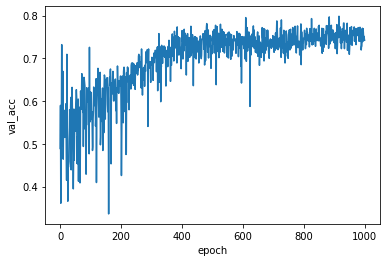

In [20]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('val_acc')

Now the model is tested against the validation data to get a final score for the model. This is done over a very small amount of data in the intrest of time and because this is not our final evaluation metric.

y=1.000 yHat=0.875
y=1.000 yHat=0.997
y=1.000 yHat=0.625
y=1.000 yHat=0.729
y=1.000 yHat=0.141
y=1.000 yHat=0.810
y=1.000 yHat=0.141
y=1.000 yHat=0.823
y=1.000 yHat=0.856
y=1.000 yHat=0.769
Model prediction accuracy: 0.734


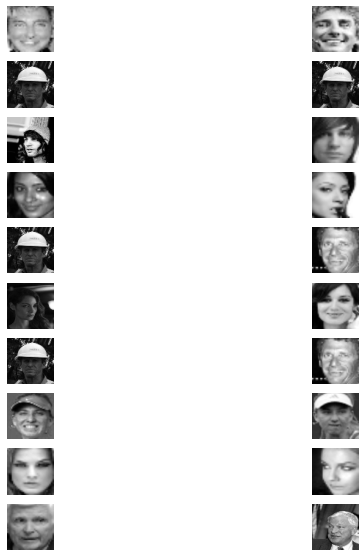

In [21]:
test_image_pairs, test_image_labels = next(test_it)
test_image_pairs_left, test_image_pairs_right = test_image_pairs
predictions = model.predict(test_image_pairs)

accuracy = np.count_nonzero([1 if p >= 0.5 else 0 for p in predictions] == test_image_labels)/len(test_image_labels)

start = 10
items = 10
fig, ax = plt.subplots(items, 2, figsize=(10, 10))
for r in range(start, start+items):
    for c in range(0, 2):
        image = test_image_pairs[c][r]
        ax[r-start,c].imshow(image[:,:,0], cmap='gray')
        ax[r-start,c].axis('off')
    print('y=%.3f yHat=%.3f' % (test_image_labels[r], predictions[r]))

print('Model prediction accuracy: %.3f' % accuracy)

# Facial Recognition

Finally, it's time to find out a persons' identity based on their face. To do this, the test image is first paired with an image from every identity in the database (test dataset). Then the Xs are fed into the model to form the predictions. The label pertaining to the highest of these scores (from the pairing process earlier) is then returned as the matched identity.

Matched 1015 to 1073: 0.895


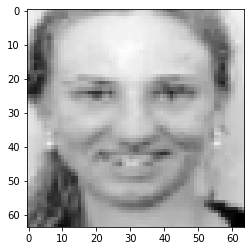

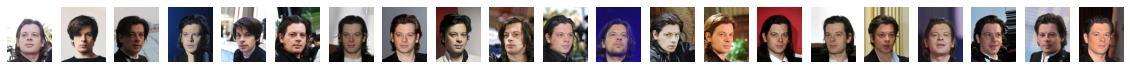

In [22]:
image, label = datagen_test.next()

def find_match(image):
    # build the data to feed into the model
    output_pairs = [np.zeros((len(datagen_test.classes), *image.shape)) for i in range(2)]
    output_pairs[0][:] = image

    # create an image pair for every identity in the database
    for i, class_name in enumerate(datagen_test.classes):
        test_img, _ = datagen_test.next(class_name)
        output_pairs[1][i,:] = test_img

    # predictions are then made for the pairs
    predictions = model.predict(output_pairs)
    classes = np.array(datagen_test.classes)
    
    # the matched class corresponds to the pair with the highest prediction value
    matched_class = classes[(predictions == predictions.max()).T[0]][0]
    return matched_class, predictions.max()

matched_class, confidence = find_match(image)
print('Matched %d to %d: %.3f' % (label, matched_class, confidence))

plt.imshow(image[:,:,0], cmap='gray')
show_class(str(matched_class), 'test')

# Final Scoring
The final metric for the model is then calculated by guessing the identity of 100 random images. The sample is rather small due to the time required for this calculation.

In [23]:
n_trials = 100
n_correct = 0
for i in tqdm(range(n_trials)):
    # a random image is pulled from the test set
    image, label = datagen_test.next()
    
    # the model then runs 20 seperate times to guess the identity of the person
    # more trials here help with outliers during the prediction process
    matches = np.zeros(20, dtype=int)
    for i in range(0, 20):
        matches[i] = find_match(image)[0]
    
    # the matched class is then reported as the class matched to the fact the most amount of times
    matched_class = np.bincount(matches).argmax()
    if matched_class == label:
        n_correct += 1
        
print("Accuracy: %.3f" % (n_correct/n_trials))


Accuracy: 0.450


# Results

As shown by the results, facial recognition is hard. We were not able to achieve a very high recognition accuracy but it was still well above randomly guessing. The model also does often guess identities of people very similear to those of the origional identity as shown a few cells above.

# Conclusion
From above we can see that our model despite having high validation accuracy and the identity prediction accuracy remain relatively low. This is due to numerous factors. Firstly, the model's error is going to be compounded when running comparisons between even 100 images. Second, we used a relatively large database of 100 images for our model. This means that there is more opportunity for people with very similar facial features to exist in our database. Cutting the size of this database down to just a few people would increase the prediction accuracy of the identities. Improvements to the base model could also show improvements in the final prediction accuracy. Of our 202,599 image data set, only about 20,000 images were used in training. Using all of these images in the training process would undoubtedly improve the final result. 
One of the most difficult parts of the project was the design of the Convolutional Neural Network. Getting the model to converge onto a solution proved to be incredibly challenging.

This was a very fun and intresting project. Much was learned about the design of Siamese Networks and how to work with images in machine learning projects.